# Capstone Project
## TED Talk
#### Author: Diogo Viana

#### Contact: d.cviana@outlook.com
####                 https://www.linkedin.com/in/diogo-viana/

#### BrainStation - Data Science Diploma - 2022

# Table of Contents
1. [Introduction](#Introduction)
2. [Data preparation](#Data-preparation)
2. [Single-layer RNN](#Single-layer-RNN)
3. [Deep recurrent neural networks](#Deep-recurrent-neural-networks)
4. [Trained word Embeddings](#Trained-word-Embeddings)
5. [Conclusion](#Conclusion)

### Introduction

This notebook is a continuation of the `Description_Data_Cleaning_and_EDA_TED_talk_Diogo_Viana` & `Description_Modeling_TED_talk_Diogo_Viana` notebooks where I had completed data cleaning, exploratory data analysis and modeling.

In this notebook, I used Recurrent Neural Network with the column description and by the end of it I came up with a set of words to build a description for TED talks.

The steps were the following: first I split the data into characters and found out the most frequent ones. After that I divided it into Train, Validation and Test.

By using `single-layer RNN model` to predict the next character based on input, I started with 20 epochs to see how it would perform. By the end of the 20th epochs the accuracy achieved was ~55%. It did not plateau, so I tried 50, 100 and 300 epochs where it looked like it started to plateau and the accuracy was ~61%. 

After that, I performed a `Word-level generation`. I used `deep recurrent neural networks`, this time, I already started with 300 epochs and training and validation did plateau and achieved 21% accuracy, but it did not plateau. So, I tried 500 epochs and accuracy changed only 1%, going up to 22%.

By the end, I finally found a set of words where I generated an ideal description of TED talk.

**Please, do not forget to run this Notebook in the deep learning Conda Environment as mentioned in the README.txt.**

In [1]:
# Let's load up some libraries
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

In this part I will use Recurrent Neural Network and divide the `transcript` column to better understand the words that result in more views.

### Data preparation

#### Splitting the Data into Characters

In [2]:
# Loading data

df = pd.read_csv('talks_info_clean.csv', index_col=0)
df.head(2)

,ted_event,page_url,speaker_information,description,title,views,recorded_month,published_month,published_year,count_related_videos,count_subtitle_languages,count_topics,popularity_ratio
duration,,,,,,,,,,,,,
992,TED2006,https://www.ted.com/talks/mena_trott_meet_the_...,"[{""name"":""Mena Trott"",""occupation"":""Blogger; c...","The founding mother of the blog revolution, Mo...",Meet the founder of the blog revolution,589115,2,8,2006,6,21,8,2.885684
957,TED2006,https://www.ted.com/talks/al_gore_averting_the...,"[{""name"":""Al Gore"",""occupation"":""Climate advoc...",With the same humor and humanity he exuded in ...,Averting the climate crisis,3671801,2,6,2006,6,43,9,2.995805


In [3]:
# the second replace just removes repeated whitespaces
df["description"] = df["description"].str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ")

C:\Users\diogo\AppData\Local\Temp\ipykernel_10560\4156768309.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["description"] = df["description"].str.replace(r"[^a-zA-Z]", " ").str.replace(r"\s+", " ")


Now, I will build a dataset of the description. First, we will use the `Tokenizer` class from Tensorflow to preprocess the description by performing the following steps:


1. Break each description into a sequence of characters, and
2. Index the characters by numbers and map the character sequences.

Setting the following parameters:

- `char_level=True` to tokenize by characters and not words (which is the default), and 
- `lower=True` to put all characters in lowercase.

In [4]:
tokenizer = Tokenizer(char_level=True, lower=True)

tokenizer.fit_on_texts(df["description"])

Now, I can extract the most important information from the tokenizer: the two dictionaries that map characters to numbers and numbers back to characters.

In [5]:
char_to_number = tokenizer.word_index
number_to_char = tokenizer.index_word

all_chars = list(char_to_number.keys())

In [6]:
#Checking characters and their assigned indices:

char_to_number

{' ': 1,
 'e': 2,
 't': 3,
 'a': 4,
 'o': 5,
 'i': 6,
 'n': 7,
 's': 8,
 'r': 9,
 'h': 10,
 'l': 11,
 'd': 12,
 'c': 13,
 'u': 14,
 'm': 15,
 'g': 16,
 'p': 17,
 'f': 18,
 'w': 19,
 'y': 20,
 'b': 21,
 'v': 22,
 'k': 23,
 'x': 24,
 'j': 25,
 'z': 26,
 'q': 27}

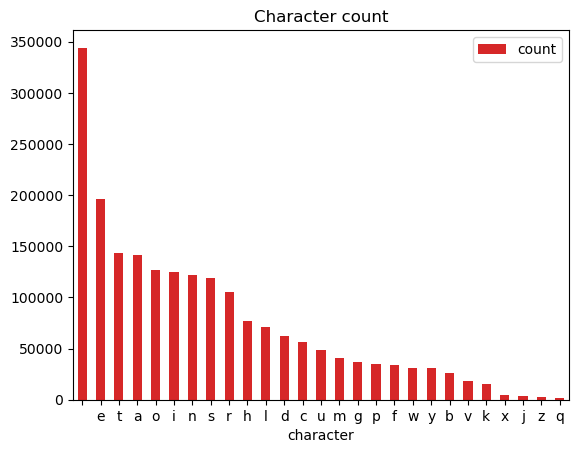

In [7]:
# Ploting the top 10 most frequent character:

character_frequency = pd.DataFrame(data=tokenizer.word_counts.items(), columns=["character", "count"])
character_frequency = character_frequency.sort_values("count", ascending=False)

character_frequency.set_index("character").plot(kind="bar", color="tab:red", rot=0, title="Character count");

As expected, space got the highest usage according to the above graphic.

Next I will use the `texts_to_sequences` method of the tokenizer object to transform the raw text to sequences of indices:

In [8]:
dataset = tokenizer.texts_to_sequences(df["description"])

In [9]:
# This is the first line of transcript in our dataset, with its characters mapped to indices

print(dataset[0])

[3, 10, 2, 1, 18, 5, 14, 7, 12, 6, 7, 16, 1, 15, 5, 3, 10, 2, 9, 1, 5, 18, 1, 3, 10, 2, 1, 21, 11, 5, 16, 1, 9, 2, 22, 5, 11, 14, 3, 6, 5, 7, 1, 15, 5, 22, 4, 21, 11, 2, 1, 3, 20, 17, 2, 1, 8, 1, 15, 2, 7, 4, 1, 3, 9, 5, 3, 3, 1, 3, 4, 11, 23, 8, 1, 4, 21, 5, 14, 3, 1, 3, 10, 2, 1, 2, 4, 9, 11, 20, 1, 12, 4, 20, 8, 1, 5, 18, 1, 21, 11, 5, 16, 16, 6, 7, 16, 1, 19, 10, 2, 7, 1, 8, 10, 2, 1, 9, 2, 4, 11, 6, 26, 2, 12, 1, 3, 10, 4, 3, 1, 16, 6, 22, 6, 7, 16, 1, 9, 2, 16, 14, 11, 4, 9, 1, 17, 2, 5, 17, 11, 2, 1, 3, 10, 2, 1, 17, 5, 19, 2, 9, 1, 3, 5, 1, 8, 10, 4, 9, 2, 1, 5, 14, 9, 1, 11, 6, 22, 2, 8, 1, 5, 7, 11, 6, 7, 2, 1, 6, 8, 1, 3, 10, 2, 1, 23, 2, 20, 1, 3, 5, 1, 21, 14, 6, 11, 12, 6, 7, 16, 1, 4, 1, 18, 9, 6, 2, 7, 12, 11, 6, 2, 9, 1, 15, 5, 9, 2, 1, 13, 5, 7, 7, 2, 13, 3, 2, 12, 1, 19, 5, 9, 11, 12, 1]


In [10]:
# sliding window
SEQUENCE_LENGTH = 10

X = []
y = []

for transcript in dataset:
    for window_start_idx in range(len(transcript)-SEQUENCE_LENGTH):
        window_end_idx = window_start_idx + SEQUENCE_LENGTH
        X.append(transcript[window_start_idx: window_end_idx])
        y.append(transcript[window_end_idx])

X = np.array(X)
y = np.array(y)

# Let's look at the shapes
print(X.shape)
print(y.shape)

(1962160, 10)
(1962160,)


As we could see, our X has 1,962,160 rows and 10 columns. While y has 1,962,160 rows and 1 column.

In [11]:
# Checking X and y:

for i in range(5):
    print("X:", X[i])
    print("y:", y[i])
    print("***Next Line***")

X: [ 3 10  2  1 18  5 14  7 12  6]
y: 7
***Next Line***
X: [10  2  1 18  5 14  7 12  6  7]
y: 16
***Next Line***
X: [ 2  1 18  5 14  7 12  6  7 16]
y: 1
***Next Line***
X: [ 1 18  5 14  7 12  6  7 16  1]
y: 15
***Next Line***
X: [18  5 14  7 12  6  7 16  1 15]
y: 5
***Next Line***


In [12]:
# Checking if the numbers match the letters

for i in range(5):
    print("X:", [number_to_char[num] for num in X[i]])
    print("y:", number_to_char[y[i]])
    print("*******")

X: ['t', 'h', 'e', ' ', 'f', 'o', 'u', 'n', 'd', 'i']
y: n
*******
X: ['h', 'e', ' ', 'f', 'o', 'u', 'n', 'd', 'i', 'n']
y: g
*******
X: ['e', ' ', 'f', 'o', 'u', 'n', 'd', 'i', 'n', 'g']
y:  
*******
X: [' ', 'f', 'o', 'u', 'n', 'd', 'i', 'n', 'g', ' ']
y: m
*******
X: ['f', 'o', 'u', 'n', 'd', 'i', 'n', 'g', ' ', 'm']
y: o
*******


In [13]:
df['description']

duration
992     The founding mother of the blog revolution Mov...
957     With the same humor and humanity he exuded in ...
1266    New York Times columnist David Pogue takes aim...
1126    Legendary scientist David Deutsch puts theoret...
1524    Jehane Noujaim unveils her TED Prize wish to b...
                              ...                        
278     In Mali produced over tons of gold an amount w...
940     Forget home economics and standardized tests e...
1048    What if the commonly accepted narratives about...
651     Your closet is likely full of all kinds of mat...
649     Could DAOs or decentralized autonomous organiz...
Name: description, Length: 5630, dtype: object

Now, I will split the data into Train, Validation and Test sets.

First, I am splitting into `Remainder` and `Test`, then splitting the `Remainder` into `Train` and `Validation.

In [14]:
# import the train test split
from sklearn.model_selection import train_test_split

# Taking a chuck for our 20% test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [15]:
# Checking after the first split

display(X_remainder.shape)
display(X_test.shape)

display(y_remainder.shape)
display(y_test.shape)

(1569728, 10)

(392432, 10)

(1569728,)

(392432,)

In [16]:
# Splitting the remainder in two chunks

X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3, stratify=y_remainder , random_state=42)

In [17]:
# Checking after the second split

display(X_train.shape)
display(X_validation.shape)

display(y_train.shape)
display(y_validation.shape)

(1098809, 10)

(470919, 10)

(1098809,)

(470919,)

As we could observe, X_train and y_train have 1,098,809 rows and X_validation and y_validation have 470,919 rows.

Now, I will use embedding layers and assign random, relatively low dimensional vector to each possible index

In [18]:
number_of_classes = len(all_chars) + 1
embedding_dim = 8

# initilize an embedding layer
embedding_layer = Embedding(number_of_classes, embedding_dim) 

In [19]:
one_window = X[0] # shape: (10) 

embedding_layer(one_window).numpy() # shape: (10, embedding_dim)

array([[ 0.04552117,  0.00576085,  0.02982107, -0.01437169,  0.03529933,
         0.01475682,  0.01541984, -0.04549167],
       [ 0.01133423, -0.02507459,  0.01063422, -0.00774287,  0.00145035,
        -0.02822026,  0.02106248, -0.02486094],
       [-0.0460358 , -0.01489896,  0.03733167, -0.03751881,  0.036666  ,
        -0.00719141, -0.0233181 , -0.02276831],
       [-0.01125362, -0.03137438,  0.01404795, -0.01928424, -0.02523631,
         0.00820805,  0.03794206, -0.0298003 ],
       [-0.00833312, -0.01136762,  0.02581085,  0.03119187, -0.01557032,
        -0.01904604,  0.01648268, -0.02993025],
       [ 0.00506598,  0.04408023, -0.00263083,  0.03300926,  0.01802573,
         0.00945745, -0.0480944 , -0.04992582],
       [-0.03586701,  0.04843089,  0.01598686,  0.00197152,  0.02850795,
        -0.04078548, -0.02097341, -0.01753002],
       [ 0.01845816,  0.04300089, -0.02799087, -0.02194147, -0.04844956,
        -0.02148056, -0.00393298,  0.03175745],
       [ 0.00713538, -0.00026126

Since it is eight-dimensional embeddings, it is hard to visualise. So, I will apply PCA in the next line to reduce it to two dimensions. And then, I will plot the letters.

In [20]:
from sklearn.decomposition import PCA

all_embeddings = embedding_layer(np.arange(number_of_classes))

pca = PCA(n_components=2)

all_embeddings_2d = pca.fit_transform(all_embeddings)

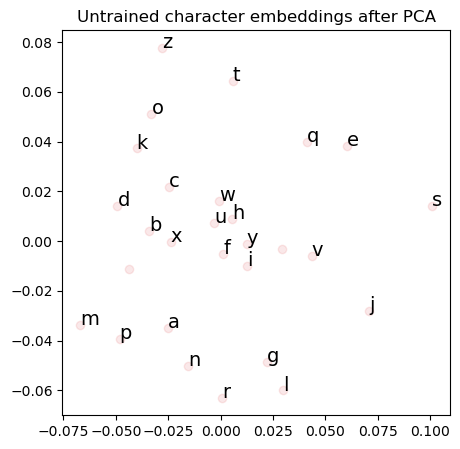

In [21]:
plt.figure(figsize=(5, 5))

# plot the PCA components
plt.scatter(all_embeddings_2d[:, 0], all_embeddings_2d[:, 1], color="tab:red", alpha=0.1)

# add characters to the plot
for num, char in number_to_char.items():
    plt.text(all_embeddings_2d[num, 0], all_embeddings_2d[num, 1], char, fontsize=14)

plt.title("Untrained character embeddings after PCA")
plt.show()

### Single-layer RNN

The character-level language model will consist of:

- an embedding layer that produces 8-dimensional character-vectors,
- a single LSTM layer with 128 units,
- a dense hidden layer with 64 units, and
- an output layer.

The model will aim to predict the next character based on the input, so the final layer should return probabilities over the possible characters (hence the softmax activation). The LSTM and dense layers are followed by batch normalization layers that help the learning process.

In [22]:
RNN_charlevel = Sequential()
RNN_charlevel.add(Embedding(number_of_classes, 8))

RNN_charlevel.add(LSTM(128, activation='relu', return_sequences=False))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(64, activation='relu'))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(number_of_classes, activation='softmax'))

In [23]:
# Compile model
RNN_charlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

C:\Users\diogo\anaconda4\envs\tedtalk\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [24]:
# Display its summary
RNN_charlevel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           224       
_________________________________________________________________
lstm (LSTM)                  (None, 128)               70144     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 28)                1820      
Total params: 81,212
Trainable params: 80,828
Non-trainable params: 384
__________________________________________________

In [25]:
history = RNN_charlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=20,
        validation_data=(X_test, y_test))

# Chanhe the name to test

Epoch 1/20
1074/1074 [==============================] - 77s 70ms/step - loss: 2.1372 - accuracy: 0.3649 - val_loss: 2.0645 - val_accuracy: 0.3762
Epoch 2/20
1074/1074 [==============================] - 68s 64ms/step - loss: 1.8692 - accuracy: 0.4311 - val_loss: 1.8883 - val_accuracy: 0.4294
Epoch 3/20
1074/1074 [==============================] - 72s 67ms/step - loss: 1.7806 - accuracy: 0.4571 - val_loss: 1.7936 - val_accuracy: 0.4549
Epoch 4/20
1074/1074 [==============================] - 69s 64ms/step - loss: 1.7228 - accuracy: 0.4746 - val_loss: 1.7443 - val_accuracy: 0.4692
Epoch 5/20
1074/1074 [==============================] - 71s 66ms/step - loss: 1.6784 - accuracy: 0.4880 - val_loss: 1.7141 - val_accuracy: 0.4791
Epoch 6/20
1074/1074 [==============================] - 79s 73ms/step - loss: 1.6451 - accuracy: 0.4984 - val_loss: 1.6564 - val_accuracy: 0.4962
Epoch 7/20
1074/1074 [==============================] - 62s 58ms/step - loss: 1.6179 - accuracy: 0.5066 - val_loss: 1.6315 -

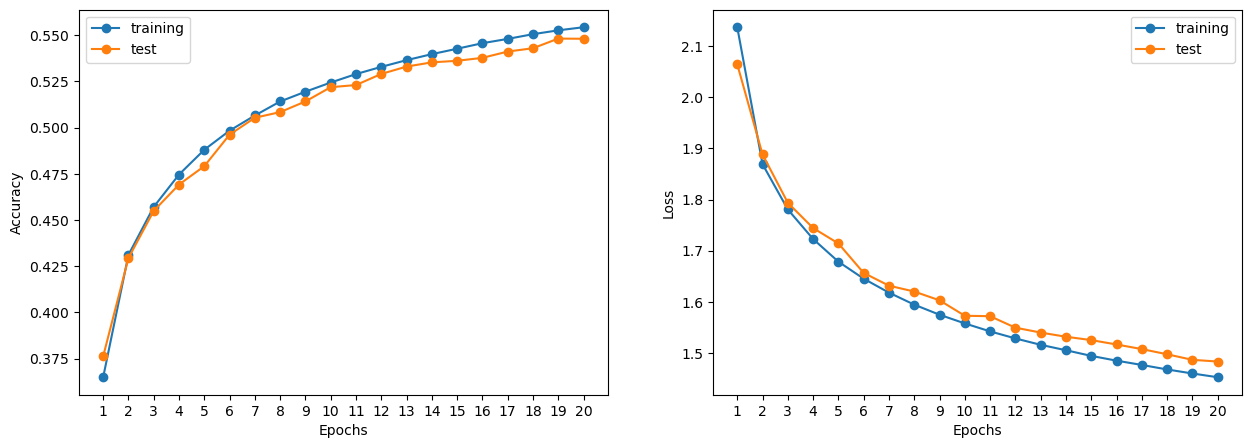

In [26]:
epochs = range(1, 21)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="test", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="test", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

Looking at the training metrics, we could observe that the validation and training loss decrease in parallel (therefore, there is no overfitting), however it did not plateau at the end of the 20th epoch. Therefore, I will try with 50 epochs. 

In [27]:
RNN_charlevel = Sequential()
RNN_charlevel.add(Embedding(number_of_classes, 8))

RNN_charlevel.add(LSTM(128, activation='relu', return_sequences=False))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(64, activation='relu'))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(number_of_classes, activation='softmax'))

In [28]:
# Compile model
RNN_charlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [29]:
# Display its summary
RNN_charlevel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 8)           224       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               70144     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 28)                1820      
Total params: 81,212
Trainable params: 80,828
Non-trainable params: 384
________________________________________________

In [30]:
history = RNN_charlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=50,
        validation_data=(X_test, y_test))

# Chanhe the name to test

Epoch 1/50
1074/1074 [==============================] - 74s 67ms/step - loss: 2.1282 - accuracy: 0.3636 - val_loss: 2.0169 - val_accuracy: 0.3912
Epoch 2/50
1074/1074 [==============================] - 71s 66ms/step - loss: 1.8719 - accuracy: 0.4307 - val_loss: 1.8648 - val_accuracy: 0.4312
Epoch 3/50
1074/1074 [==============================] - 71s 66ms/step - loss: 1.7818 - accuracy: 0.4574 - val_loss: 1.7963 - val_accuracy: 0.4542
Epoch 4/50
1074/1074 [==============================] - 71s 66ms/step - loss: 1.7244 - accuracy: 0.4741 - val_loss: 1.7508 - val_accuracy: 0.4673
Epoch 5/50
1074/1074 [==============================] - 72s 67ms/step - loss: 1.6815 - accuracy: 0.4874 - val_loss: 1.7040 - val_accuracy: 0.4823
Epoch 6/50
1074/1074 [==============================] - 72s 67ms/step - loss: 1.6480 - accuracy: 0.4978 - val_loss: 1.6735 - val_accuracy: 0.4887
Epoch 7/50
1074/1074 [==============================] - 71s 66ms/step - loss: 1.6200 - accuracy: 0.5066 - val_loss: 1.6466 -

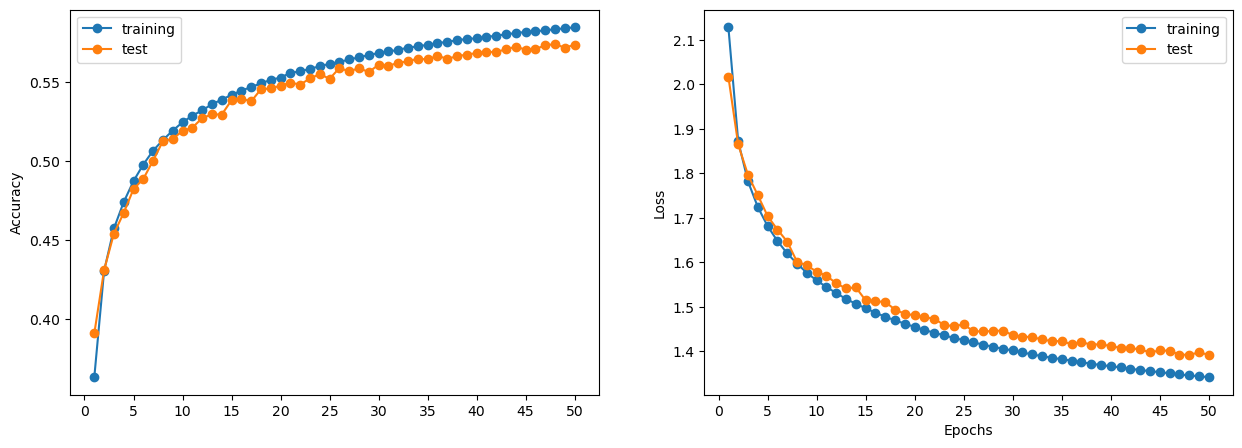

In [31]:
epochs = range(1, 51)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="test", marker="o")
plt.xticks(np.arange(0, len(epochs)+1, 5))
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="test", marker="o")
plt.xlabel("Epochs")
plt.xticks(np.arange(0, len(epochs)+1, 5))
plt.ylabel("Loss")
plt.legend()
plt.show()

The training and validation are still decreasing in parallel, but they have not plateaued yet. Therefore, I will try with 100 epochs and check how it goes. 

In [32]:
RNN_charlevel = Sequential()
RNN_charlevel.add(Embedding(number_of_classes, 8))

RNN_charlevel.add(LSTM(128, activation='relu', return_sequences=False))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(64, activation='relu'))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(number_of_classes, activation='softmax'))

In [33]:
# Compile model
RNN_charlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [34]:
# Display its summary
RNN_charlevel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 8)           224       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               70144     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 28)                1820      
Total params: 81,212
Trainable params: 80,828
Non-trainable params: 384
________________________________________________

In [35]:
history = RNN_charlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=100,
        validation_data=(X_test, y_test))

# Chanhe the name to test

Epoch 1/100
1074/1074 [==============================] - 75s 68ms/step - loss: 2.1333 - accuracy: 0.3626 - val_loss: 2.0351 - val_accuracy: 0.3869
Epoch 2/100
1074/1074 [==============================] - 73s 68ms/step - loss: 1.8684 - accuracy: 0.4318 - val_loss: 1.8998 - val_accuracy: 0.4232
Epoch 3/100
1074/1074 [==============================] - 74s 68ms/step - loss: 1.7758 - accuracy: 0.4584 - val_loss: 1.7928 - val_accuracy: 0.4541
Epoch 4/100
1074/1074 [==============================] - 72s 67ms/step - loss: 1.7183 - accuracy: 0.4757 - val_loss: 1.7310 - val_accuracy: 0.4749
Epoch 5/100
1074/1074 [==============================] - 74s 69ms/step - loss: 1.6770 - accuracy: 0.4894 - val_loss: 1.6985 - val_accuracy: 0.4824
Epoch 6/100
1074/1074 [==============================] - 75s 69ms/step - loss: 1.6446 - accuracy: 0.4990 - val_loss: 1.6720 - val_accuracy: 0.4928
Epoch 7/100
1074/1074 [==============================] - 74s 69ms/step - loss: 1.6182 - accuracy: 0.5065 - val_loss: 1

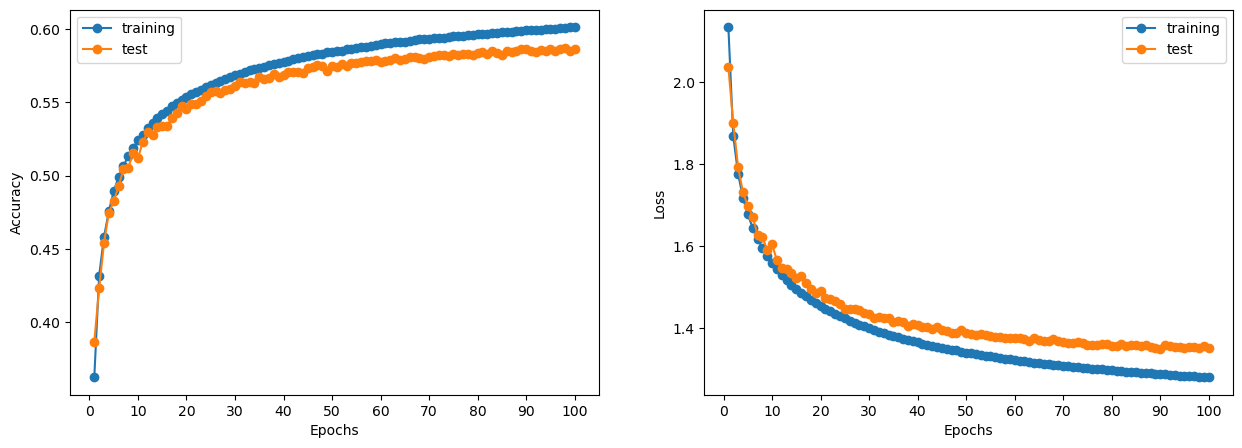

In [36]:
epochs = range(1, 101)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="test", marker="o")
plt.xlabel("Epochs")
#plt.xticks(epochs)
plt.xticks(np.arange(0, len(epochs)+1, 10))
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="test", marker="o")
plt.xlabel("Epochs")
#plt.xticks(epochs)
plt.xticks(np.arange(0, len(epochs)+1, 10))
plt.ylabel("Loss")
plt.legend()
plt.show()

It is possible to see that even if using 100 epochs it did not plateau yet. Therefore, I will try with 300 epochs and check how it goes. 

In [37]:
RNN_charlevel = Sequential()
RNN_charlevel.add(Embedding(number_of_classes, 8))

RNN_charlevel.add(LSTM(128, activation='relu', return_sequences=False))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(64, activation='relu'))
RNN_charlevel.add(BatchNormalization())

RNN_charlevel.add(Dense(number_of_classes, activation='softmax'))

In [38]:
# Compile model
RNN_charlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [39]:
# Display its summary
RNN_charlevel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 8)           224       
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               70144     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 28)                1820      
Total params: 81,212
Trainable params: 80,828
Non-trainable params: 384
________________________________________________

In [40]:
history = RNN_charlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=300,
        validation_data=(X_test, y_test))

# Chanhe the name to test

Epoch 1/300
1074/1074 [==============================] - 71s 64ms/step - loss: 2.1213 - accuracy: 0.3656 - val_loss: 2.0382 - val_accuracy: 0.3797
Epoch 2/300
1074/1074 [==============================] - 68s 64ms/step - loss: 1.8683 - accuracy: 0.4304 - val_loss: 1.8969 - val_accuracy: 0.4178
Epoch 3/300
1074/1074 [==============================] - 68s 64ms/step - loss: 1.7806 - accuracy: 0.4572 - val_loss: 1.8742 - val_accuracy: 0.4353
Epoch 4/300
1074/1074 [==============================] - 68s 63ms/step - loss: 1.7241 - accuracy: 0.4749 - val_loss: 1.7362 - val_accuracy: 0.4713
Epoch 5/300
1074/1074 [==============================] - 69s 64ms/step - loss: 1.6804 - accuracy: 0.4888 - val_loss: 1.7155 - val_accuracy: 0.4797
Epoch 6/300
1074/1074 [==============================] - 70s 65ms/step - loss: 1.6473 - accuracy: 0.4985 - val_loss: 1.6710 - val_accuracy: 0.4938
Epoch 7/300
1074/1074 [==============================] - 71s 66ms/step - loss: 1.6199 - accuracy: 0.5069 - val_loss: 1

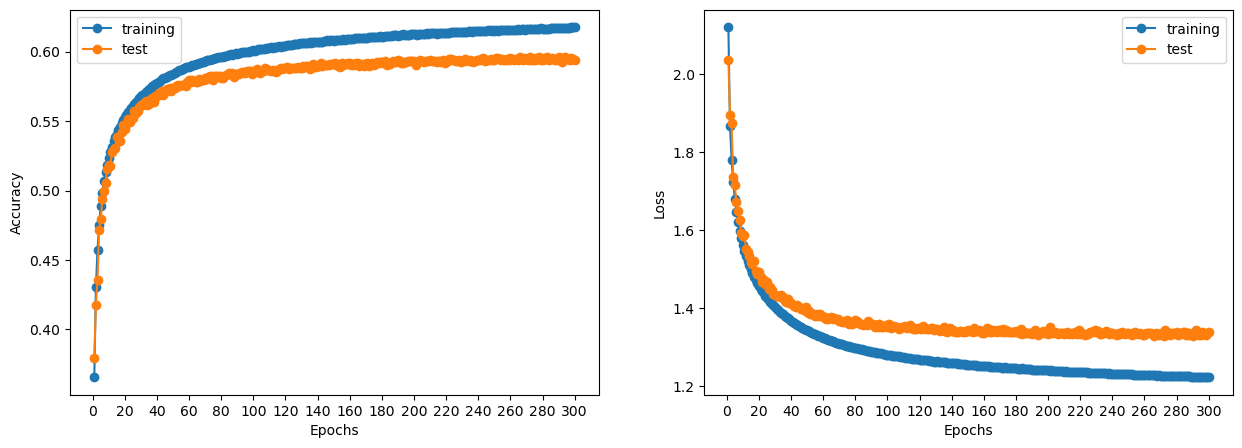

In [41]:
epochs = range(1, 301)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="test", marker="o")
plt.xlabel("Epochs")
#plt.xticks(epochs)
plt.xticks(np.arange(0, len(epochs)+1, 20))
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="test", marker="o")
plt.xlabel("Epochs")
plt.xticks(np.arange(0, len(epochs)+1, 20))
plt.ylabel("Loss")
plt.legend()
plt.show()

After trying 300 epochs, it looks like it starts to plateau.

Since I am interested in realistic text generation rather than accuracy, I will perform a Word-level text generation.

The vocabulary will be much bigger, but the model will at least output proper English words. For this to happen, the `char_level` will be set equal to `False`.

In [42]:
# Note: char_level is False now
tokenizer = Tokenizer(char_level=False, lower=True) 
tokenizer.fit_on_texts(df['description'])

In [43]:
word_to_number = tokenizer.word_index
number_to_word = tokenizer.index_word

all_words = list(word_to_number.keys())

print(f"Vocabulary size: {len(all_words)}")

Vocabulary size: 26060


In [44]:
dataset = tokenizer.texts_to_sequences(df['description'])

In [45]:
# This is the first transcript in the dataset, displayed using its word numbers

print(dataset[0])

[1, 3397, 894, 4, 1, 6429, 770, 14079, 1686, 8, 9788, 14080, 204, 30, 1, 556, 510, 4, 6430, 55, 27, 1265, 7, 823, 3168, 45, 1, 109, 3, 342, 24, 138, 351, 15, 1, 357, 3, 281, 5, 9789, 37, 1266, 34]


In [46]:
# sliding window
SEQUENCE_LENGTH = 5

X = []
y = []

for poem in dataset:
    for window_start_idx in range(len(poem)-SEQUENCE_LENGTH):
        window_end_idx = window_start_idx + SEQUENCE_LENGTH
        X.append(poem[window_start_idx: window_end_idx])
        y.append(poem[window_end_idx])

X = np.array(X)
y = np.array(y)

# Let's look at the shapes
print(X.shape)
print(y.shape)

(315788, 5)
(315788,)


In [47]:
for i in range(5):
    print("X:", X[i])
    print("y:", y[i])
    print("*******")

X: [   1 3397  894    4    1]
y: 6429
*******
X: [3397  894    4    1 6429]
y: 770
*******
X: [ 894    4    1 6429  770]
y: 14079
*******
X: [    4     1  6429   770 14079]
y: 1686
*******
X: [    1  6429   770 14079  1686]
y: 8
*******


In [48]:
for i in range(5):
    print("X:", [number_to_word[num] for num in X[i]])
    print("y:", number_to_word[y[i]])
    print("*******")

X: ['the', 'founding', 'mother', 'of', 'the']
y: blog
*******
X: ['founding', 'mother', 'of', 'the', 'blog']
y: revolution
*******
X: ['mother', 'of', 'the', 'blog', 'revolution']
y: movable
*******
X: ['of', 'the', 'blog', 'revolution', 'movable']
y: type
*******
X: ['the', 'blog', 'revolution', 'movable', 'type']
y: s
*******


In [49]:
# Taking a chuck for our 20% test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [50]:
# Checking after the first split

print(X_remainder.shape, y_remainder.shape)
print(X_test.shape, y_test.shape)

(252630, 5) (252630,)
(63158, 5) (63158,)


In [51]:
# Splitting the remainder in two chunks

X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3, random_state=42)

In [52]:
# Checking after the second split

print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(176841, 5) (176841,)
(75789, 5) (75789,)


### Deep recurrent neural networks

For the language model, I will use two recurrent layers before the dense and output layers. Because, with more layers, the model can learn more complex relationships between the preceding words.

In [53]:
number_of_classes = len(all_words)+1

RNN_wordlevel = Sequential()
RNN_wordlevel.add(Embedding(number_of_classes, 8))

# the intermediate recurrent layers should return full sequences
RNN_wordlevel.add(GRU(64, activation='relu', return_sequences=True))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

# the last recurrent layer only returns the final output
RNN_wordlevel.add(GRU(32, activation='relu', return_sequences=False))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

RNN_wordlevel.add(Dense(16, activation='relu'))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

RNN_wordlevel.add(Dense(number_of_classes, activation='softmax'))

In [54]:
# Compile model
RNN_wordlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [55]:
# Display its summary
RNN_wordlevel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 8)           208488    
_________________________________________________________________
gru (GRU)                    (None, None, 64)          14208     
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 64)          256       
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

We can observe that the final layer is learning a probability distribution over ~25k possible words.

I will start by using 300 epochs and see how it goes.

In [56]:
history = RNN_wordlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=300,
        validation_data=(X_test, y_test))

Epoch 1/300
173/173 [==============================] - 48s 264ms/step - loss: 9.8020 - accuracy: 0.0475 - val_loss: 9.3479 - val_accuracy: 0.0334
Epoch 2/300
173/173 [==============================] - 43s 251ms/step - loss: 8.0892 - accuracy: 0.0856 - val_loss: 7.7300 - val_accuracy: 0.0669
Epoch 3/300
173/173 [==============================] - 43s 251ms/step - loss: 7.0049 - accuracy: 0.1022 - val_loss: 7.1569 - val_accuracy: 0.0815
Epoch 4/300
173/173 [==============================] - 43s 251ms/step - loss: 6.7117 - accuracy: 0.1124 - val_loss: 6.9318 - val_accuracy: 0.1024
Epoch 5/300
173/173 [==============================] - 44s 252ms/step - loss: 6.5603 - accuracy: 0.1185 - val_loss: 6.9040 - val_accuracy: 0.1113
Epoch 6/300
173/173 [==============================] - 44s 252ms/step - loss: 6.4623 - accuracy: 0.1233 - val_loss: 6.8944 - val_accuracy: 0.1149
Epoch 7/300
173/173 [==============================] - 43s 251ms/step - loss: 6.3832 - accuracy: 0.1271 - val_loss: 6.8974 -

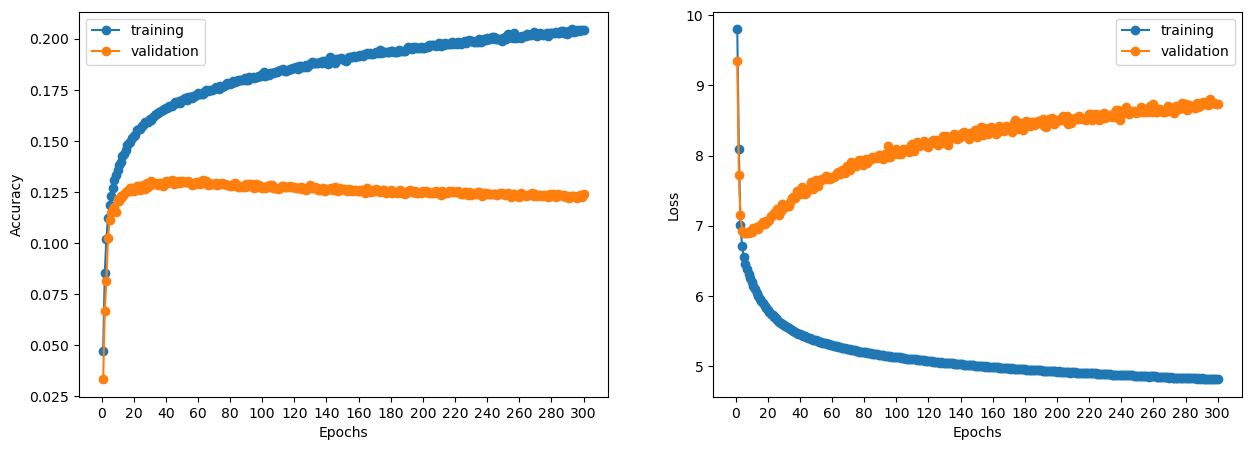

In [57]:
epochs = range(1, 301)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(np.arange(0, len(epochs)+1, 20))
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(np.arange(0, len(epochs)+1, 20))
plt.ylabel("Loss")
plt.legend()
plt.show()

In [58]:
number_of_classes = len(all_words)+1

RNN_wordlevel = Sequential()
RNN_wordlevel.add(Embedding(number_of_classes, 8))

# the intermediate recurrent layers should return full sequences
RNN_wordlevel.add(GRU(64, activation='relu', return_sequences=True))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

# the last recurrent layer only returns the final output
RNN_wordlevel.add(GRU(32, activation='relu', return_sequences=False))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

RNN_wordlevel.add(Dense(16, activation='relu'))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

RNN_wordlevel.add(Dense(number_of_classes, activation='softmax'))

In [59]:
# Compile model
RNN_wordlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [60]:
# Display its summary
RNN_wordlevel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 8)           208488    
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          14208     
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 64)          256       
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                9408      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

In [61]:
history = RNN_wordlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=500,
        validation_data=(X_test, y_test))

Epoch 1/500
173/173 [==============================] - 51s 275ms/step - loss: 9.7849 - accuracy: 0.0492 - val_loss: 9.4271 - val_accuracy: 0.0502
Epoch 2/500
173/173 [==============================] - 48s 278ms/step - loss: 8.0507 - accuracy: 0.0859 - val_loss: 7.7654 - val_accuracy: 0.0594
Epoch 3/500
173/173 [==============================] - 47s 272ms/step - loss: 7.0056 - accuracy: 0.1022 - val_loss: 7.2334 - val_accuracy: 0.0816
Epoch 4/500
173/173 [==============================] - 49s 284ms/step - loss: 6.7028 - accuracy: 0.1112 - val_loss: 6.9132 - val_accuracy: 0.1037
Epoch 5/500
173/173 [==============================] - 47s 271ms/step - loss: 6.5554 - accuracy: 0.1158 - val_loss: 6.8637 - val_accuracy: 0.1087
Epoch 6/500
173/173 [==============================] - 47s 275ms/step - loss: 6.4575 - accuracy: 0.1200 - val_loss: 6.8421 - val_accuracy: 0.1133
Epoch 7/500
173/173 [==============================] - 47s 271ms/step - loss: 6.3789 - accuracy: 0.1237 - val_loss: 6.8435 -

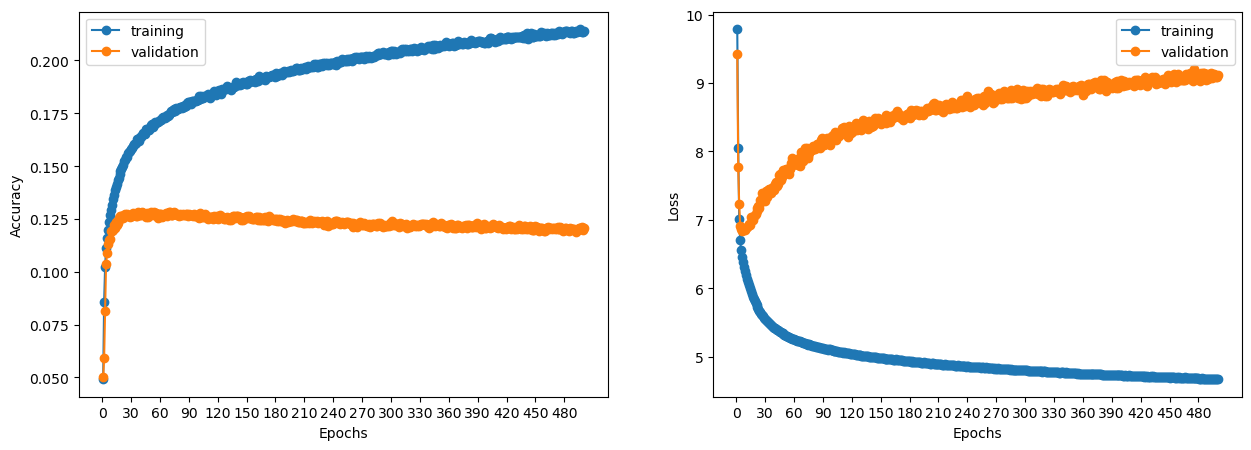

In [62]:
epochs = range(1, 501)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(np.arange(0, len(epochs)+1, 30))
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(np.arange(0, len(epochs)+1, 30))
plt.ylabel("Loss")
plt.legend()
plt.show()

In [67]:
number_of_classes = len(all_words)+1

RNN_wordlevel = Sequential()
RNN_wordlevel.add(Embedding(number_of_classes, 8))

# the intermediate recurrent layers should return full sequences
RNN_wordlevel.add(GRU(64, activation='relu', return_sequences=True))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

# the last recurrent layer only returns the final output
RNN_wordlevel.add(GRU(32, activation='relu', return_sequences=False))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

RNN_wordlevel.add(Dense(16, activation='relu'))
RNN_wordlevel.add(BatchNormalization())
RNN_wordlevel.add(Dropout(0.15))

RNN_wordlevel.add(Dense(number_of_classes, activation='softmax'))

In [68]:
# Compile model
RNN_wordlevel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

C:\Users\diogo\anaconda4\envs\tedtalk\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [69]:
# Display its summary
RNN_wordlevel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 8)           208488    
_________________________________________________________________
gru_4 (GRU)                  (None, None, 64)          14208     
_________________________________________________________________
batch_normalization_14 (Batc (None, None, 64)          256       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                9408      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32)                128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)               

In [70]:
history = RNN_wordlevel.fit(X_train, y_train,
        batch_size=1024,
        epochs=1000,
        validation_data=(X_test, y_test))

Epoch 1/1000
173/173 [==============================] - 39s 208ms/step - loss: 9.8080 - accuracy: 0.0440 - val_loss: 9.4843 - val_accuracy: 0.0352
Epoch 2/1000
173/173 [==============================] - 36s 210ms/step - loss: 8.1172 - accuracy: 0.0874 - val_loss: 7.7915 - val_accuracy: 0.0578
Epoch 3/1000
173/173 [==============================] - 38s 217ms/step - loss: 7.0919 - accuracy: 0.0984 - val_loss: 7.2331 - val_accuracy: 0.0765
Epoch 4/1000
173/173 [==============================] - 39s 224ms/step - loss: 6.7831 - accuracy: 0.1038 - val_loss: 7.0480 - val_accuracy: 0.0954
Epoch 5/1000
173/173 [==============================] - 38s 223ms/step - loss: 6.6053 - accuracy: 0.1099 - val_loss: 6.9249 - val_accuracy: 0.1044
Epoch 6/1000
173/173 [==============================] - 38s 220ms/step - loss: 6.4793 - accuracy: 0.1158 - val_loss: 6.9306 - val_accuracy: 0.1108
Epoch 7/1000
173/173 [==============================] - 38s 222ms/step - loss: 6.3793 - accuracy: 0.1221 - val_loss: 6

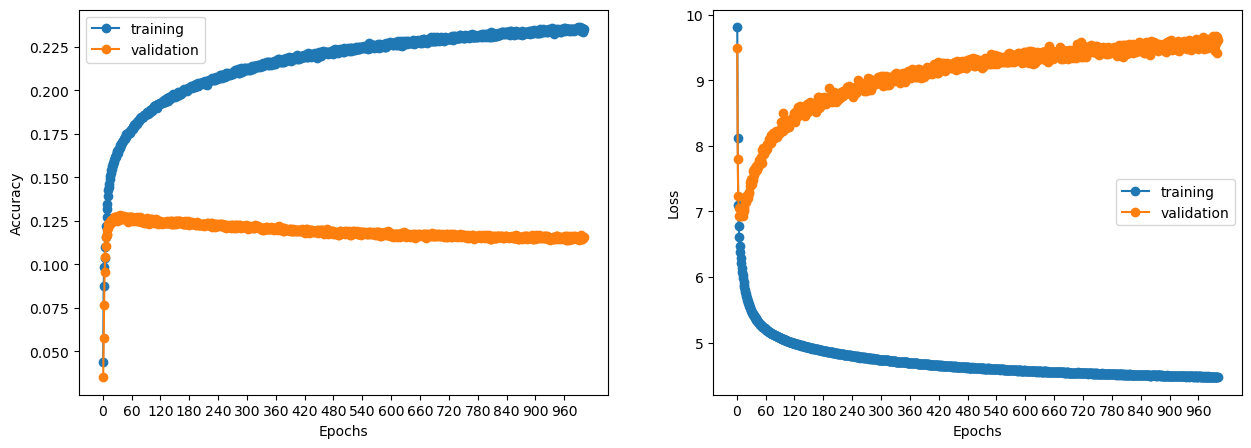

In [73]:
epochs = range(1, 1001)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(np.arange(0, len(epochs)+1, 60))
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(np.arange(0, len(epochs)+1, 60))
plt.ylabel("Loss")
plt.legend()
plt.show()

Now, I could use the same loop as before to generate text:

In [66]:
input_phrase = "In today`s TED talk."

# process for the model
processed_phrase = tokenizer.texts_to_sequences([input_phrase])[0]

for i in range(50):
    # extract last 5 words
    network_input = np.array(processed_phrase[-SEQUENCE_LENGTH:], dtype=np.float32)
    network_input = network_input.reshape((1, SEQUENCE_LENGTH)) # shape: 1 x 5

    # the RNN gives the probability of each word as the next one
    predict_proba = RNN_wordlevel.predict(network_input)[0] # shape (4855,)
    
    # sample one word using these chances
    predicted_index = np.random.choice(number_of_classes, 1, p=predict_proba)[0]

    # add new index at the end of our list
    processed_phrase.append(predicted_index)
    
    # progress indicator
    print(i, end="\r")

# indices mapped to words - the method expects a list of lists so we need the extra bracket
output_phrase = tokenizer.sequences_to_texts([processed_phrase])[0]

print(output_phrase)

in today s ted talk is bursting to be a surprising walk even and fast for water which some worth his happiness who can use that leaving the only the world your neural consumption before the three minded body this plan if you want to understand cognitive legal health and lays up their communication of


The result may not fool a human since the model failed to learn grammar with so little training. I will take a look at the work embeddings now and see if we could pick any patterns.

In [64]:
trained_embedding = RNN_wordlevel.layers[0]

all_embeddings = trained_embedding(np.arange(number_of_classes))

pca = PCA(n_components=2)

all_embeddings_2d = pca.fit_transform(all_embeddings)

### Trained word Embeddings

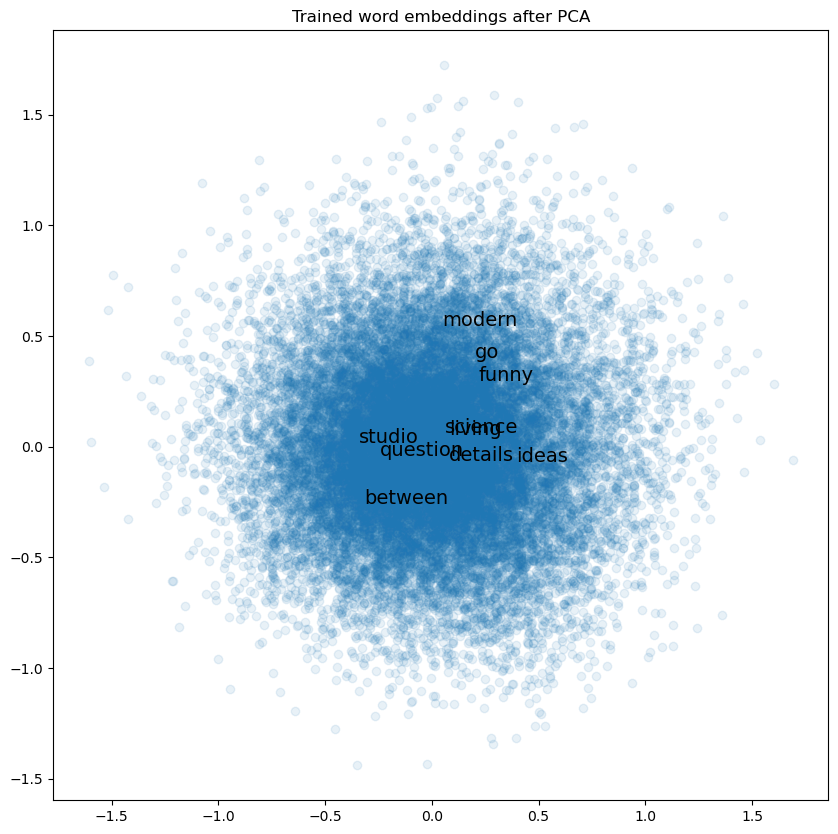

In [65]:
plt.figure(figsize=(10, 10))


plt.scatter(all_embeddings_2d[:, 0], all_embeddings_2d[:, 1], alpha=0.1)

# we select a few words based on frequency
sorted_words = sorted(tokenizer.word_counts.items(), key=lambda x: x[1])
word_sample = sorted_words[-300: -100: 20]

for word, num in word_sample:
    # some noise is added to the text position to avoid accidental overlapping
    # rerun the cell if too many words overlap
    plt.text(all_embeddings_2d[num, 0]+np.random.randn(1)*0.01, 
             all_embeddings_2d[num, 1]+np.random.randn(1)*0.01,
             word, 
             fontsize=14)

plt.title("Trained word embeddings after PCA")
plt.show()

As we can see from the above Trained word embeddings graphic, we could use these eight words to build a description.

### Conclusion

After completing the data preparation, I used the column `description` to split into characters and then split the data into Train, Validation and Test sets. The next step was performing a single-layer RNN, with an embedding layer that produces 8-dimensional character-vectors, a single LSTM layer with 128 units, a dense hidden layer with 64 units and an output layer.


The objective of using this model was to be able to predict the next character based on the input. During the process, I started by running 20 epochs, but the validation and train did not plateau. I kept trying, next I ran with 50 epochs and still not plateauing. So, I jumped to 100 epochs and then 300 epochs, where finally validation and train leveled-up. The validation got ~60% of accuracy, which is considered not bad for predicting the next character.


The following stage was performing deep recurrent neural networks. This time I already started with 300 epochs, but it did not level-up. So, I used 500 epochs and then 1000  which presented a very good result. The sentence generated by the model could not be considered as a good result, however, the set of words given by the model was very good.
Moreover, now I will construct a description based on the word embeddings.

** details | living | question | science | ideas | studio | between | modern | funny | go **

“If you do not find the idea of living paycheck to paycheck in a not modern studio apartment funny, I have a question for you. Have you ever thought of starting a career as a Data Scientist? So, in today's TED talk, I will talk about the delightful Data Science market in detail. (…)
(...) So, do not be scared and let something between you and a successful life stop you. Just GO!“

The results from the created description appear to be good. As you could see in the report, I compared the results from this model with the Decision Tree.